In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install osmnx

In [ ]:
#import pandas as pd
import pandas as pd

# Define the path to the zip file in Google Drive
file_path = '/content/drive/MyDrive/gps_data_1497.csv'


# Example for loading the first 1500 trips from train.csv
gps_data = pd.read_csv(file_path)

# Check if data is now populated
print(gps_data.head(10))


               TRIP_ID       lon        lat
0  1372636858620000589 -8.618643  41.141412
1  1372636858620000589 -8.618499  41.141376
2  1372636858620000589 -8.620326  41.142510
3  1372636858620000589 -8.622153  41.143815
4  1372636858620000589 -8.623953  41.144373
5  1372636858620000589 -8.626680  41.144778
6  1372636858620000589 -8.627373  41.144697
7  1372636858620000589 -8.630226  41.145210
8  1372636858620000589 -8.632746  41.146920
9  1372636858620000589 -8.631738  41.148225


Trips with outliers analysis
==

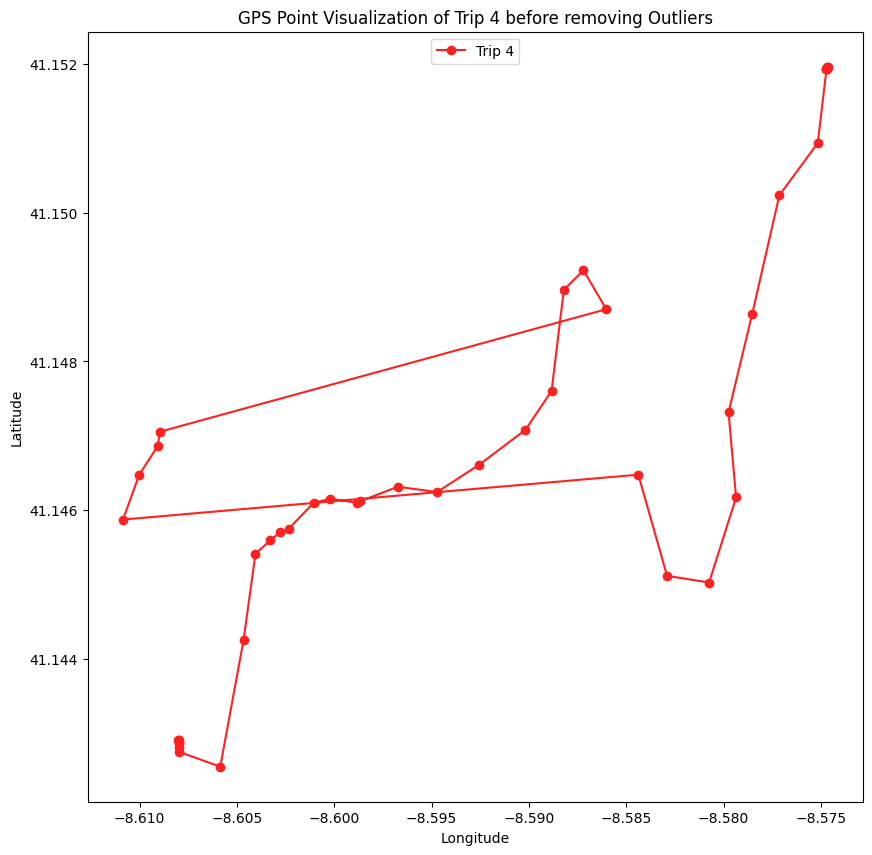

In [ ]:
import matplotlib.pyplot as plt

def plot_trip_gps_points_tripnum(gps_data, trip_id, tripnum,color='#8c564b'):
    # Filter the data for the specific TRIP_ID
    trip_data = gps_data[gps_data['TRIP_ID'] == trip_id]


    # Create a plot with longitude on the x-axis and latitude on the y-axis
    plt.figure(figsize=(10, 10))
    plt.plot(trip_data['lon'], trip_data['lat'], marker='o', linestyle='-', color=color, label=f'Trip {tripnum}')

    # Add labels and title
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'GPS Point Visualization of Trip {tripnum} before removing Outliers')
    plt.legend()
    # Place the legend at the center top of the plot
    plt.legend(loc='upper center', fontsize='medium', ncol=1)

    # Show the plot
    plt.show()

trip_id_to_plot = 1372636854620000520
tripnum=4
# Visualize the GPS points for the chosen trip with the color #8c564b
plot_trip_gps_points_tripnum(gps_data, trip_id_to_plot, tripnum,color='#FF2121')
#gps_data.head()


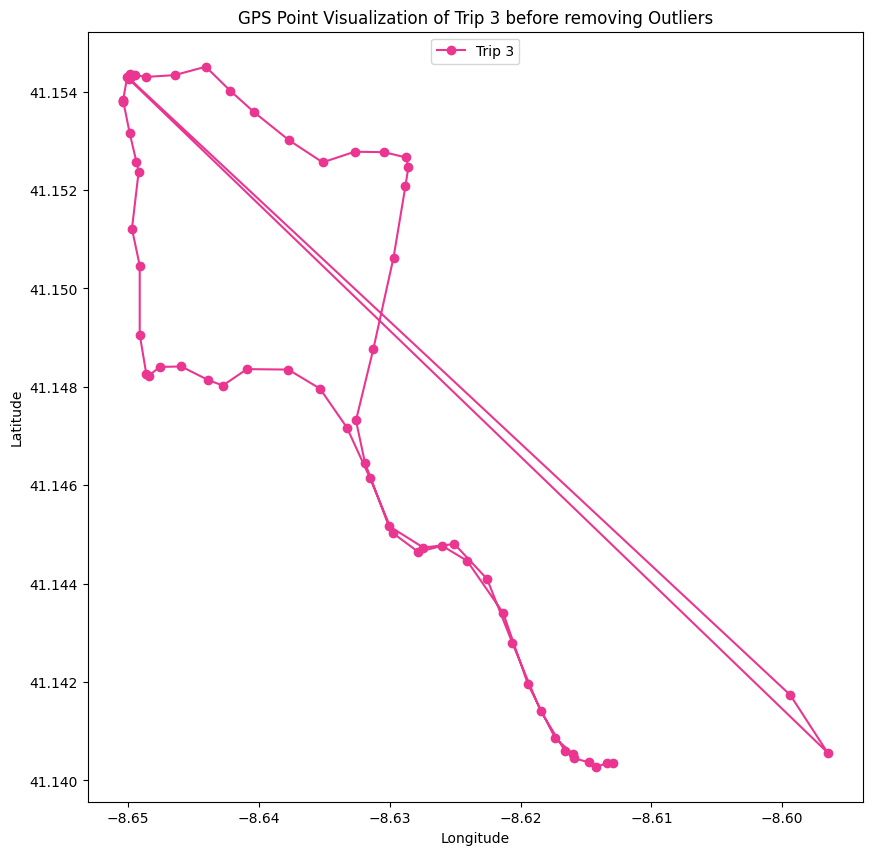

In [ ]:
trip_id_to_plot = 1372636951620000320
tripnum=3
# Visualize the GPS points for the chosen trip with the color #8c564b
plot_trip_gps_points_tripnum(gps_data, trip_id_to_plot, tripnum,color='#ea3690')

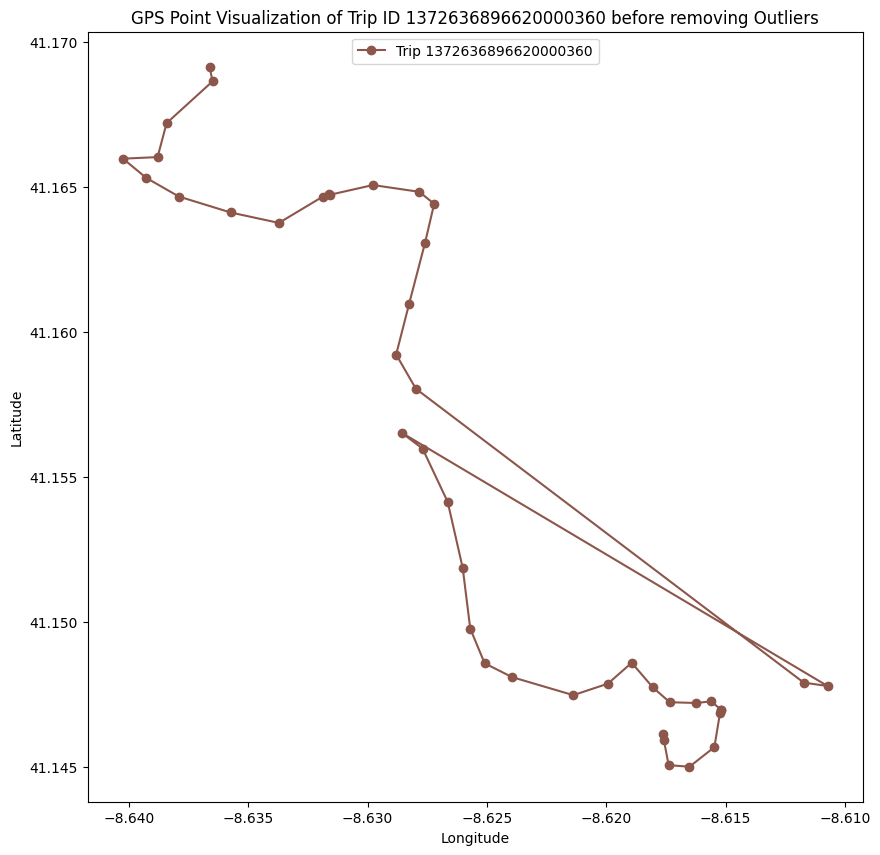

In [ ]:
import matplotlib.pyplot as plt

def plot_trip_gps_points(gps_data, trip_id, titlestring, color='#8c564b'):
    # Filter the data for the specific TRIP_ID
    trip_data = gps_data[gps_data['TRIP_ID'] == trip_id]

    # Create a plot with longitude on the x-axis and latitude on the y-axis
    plt.figure(figsize=(10, 10))
    plt.plot(trip_data['lon'], trip_data['lat'], marker='o', linestyle='-', color=color, label=f'Trip {trip_id}')

    # Add labels and title
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'GPS Point Visualization of Trip ID {trip_id} {titlestring}')
    plt.legend()

    # Place the legend at the center top of the plot
    plt.legend(loc='upper center', fontsize='medium', ncol=1)

    # Show the plot
    plt.show()

# Choose the TRIP_ID you want to plot (in this case, Trip 10)
trip_id_to_plot = 1372636896620000360

plot_trip_gps_points(gps_data, trip_id_to_plot, 'before removing Outliers', color='#8c564b')


LOF
==

In [ ]:
import numpy as np
import pandas as pd
from geopy.distance import geodesic
from sklearn.neighbors import NearestNeighbors

# Function to calculate geodesic distance
def geodesic_distance(p1, p2):
    return geodesic(p1, p2).meters  # Returns distance in meters

# Function to calculate Local Outlier Factor (LOF)
def calculate_lof_with_geodesic(gps_data, k=10):
    # Extract longitude and latitude
    points = gps_data[['lon', 'lat']].values

    # Use NearestNeighbors from sklearn to find k-nearest neighbors more efficiently
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree', metric='haversine')
    nbrs.fit(np.radians(points))  # Use radians for the 'haversine' distance

    # Get the distances to the k-nearest neighbors
    distances, indices = nbrs.kneighbors(np.radians(points))

    # Calculate k-distances for each point
    k_distances = distances[:, -1]  # The k-th nearest neighbor distance

    # Calculate reachability distances for each pair
    reachability_distances = np.maximum(k_distances[indices], distances)

    # Calculate Local Reachability Density (LRD)
    lrd_values = 1 / np.sum(reachability_distances, axis=1)

    # Calculate LOF for each point
    lof_scores = []
    for i in range(len(points)):
        neighbors = indices[i, 1:]  # Get indices of k-nearest neighbors (excluding the point itself)
        lrd_p = lrd_values[i]
        lrd_neighbors = lrd_values[neighbors]
        lof = np.mean(lrd_neighbors / lrd_p)
        lof_scores.append(lof)

    # Add LOF scores to the dataframe
    gps_data['LOF_Score'] = lof_scores

    return gps_data

# Assuming gps_data is already loaded as a DataFrame
# gps_data = pd.read_csv("your_gps_data.csv")
gps_datas=gps_data
# Calculate LOF scores for each point with k=10 and geodesic distance
gps_data_with_lof = calculate_lof_with_geodesic(gps_datas, k=10)

# Show the DataFrame with LOF scores
gps_data_with_lof.to_csv('gps_data_with_LOF.csv', index=False)
gps_data_with_lof.head(10)


<ipython-input-17-31f1944b874f>:29: RuntimeWarning: divide by zero encountered in divide
  lrd_values = 1 / np.sum(reachability_distances, axis=1)
<ipython-input-17-31f1944b874f>:37: RuntimeWarning: invalid value encountered in divide
  lof = np.mean(lrd_neighbors / lrd_p)


,TRIP_ID,lon,lat,LOF_Score
0,1372636858620000589,-8.618643,41.141412,1.015188
1,1372636858620000589,-8.618499,41.141376,0.956107
2,1372636858620000589,-8.620326,41.142510,0.993088
3,1372636858620000589,-8.622153,41.143815,1.033363
4,1372636858620000589,-8.623953,41.144373,1.036638
5,1372636858620000589,-8.626680,41.144778,1.041424
6,1372636858620000589,-8.627373,41.144697,0.991660
7,1372636858620000589,-8.630226,41.145210,0.961904
8,1372636858620000589,-8.632746,41.146920,0.947789
9,1372636858620000589,-8.631738,41.148225,1.030625


Team Proposed Method, choosing Epsilon
==

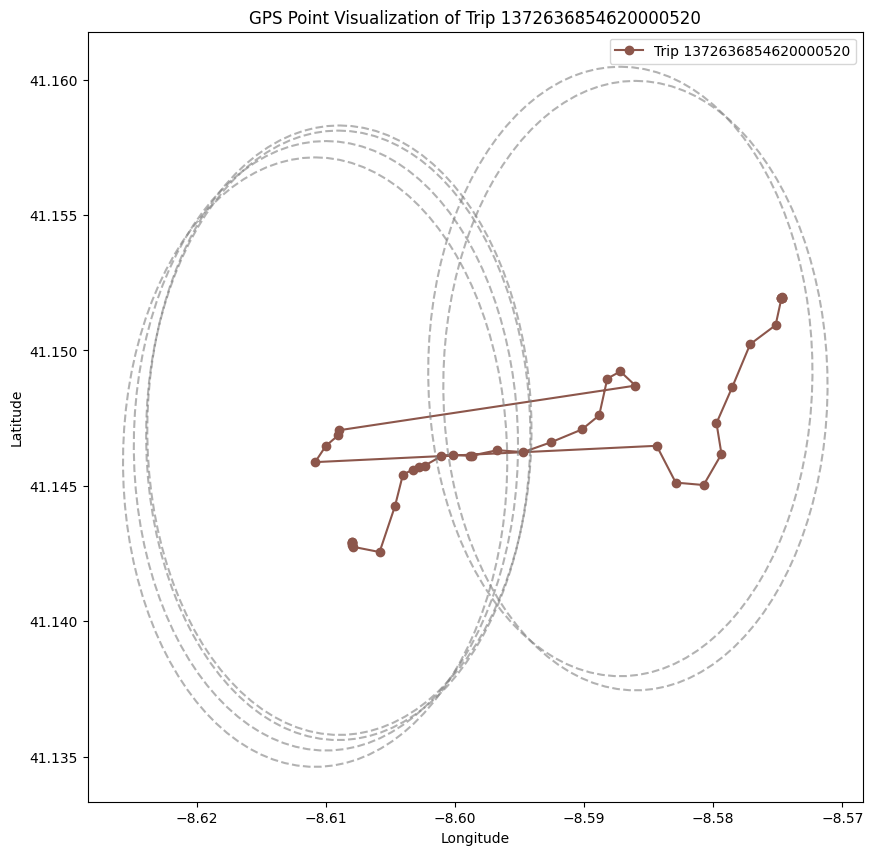

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from geopy.distance import geodesic
from geopy import Point

def plot_trip_gps_points_with_circles(gps_data, trip_id, radius_km=1.25, color='#8c564b', num_points=100, circle_indices=[22, 23, 24, 25]):
    # Filter the data for the specific TRIP_ID
    trip_data = gps_data[gps_data['TRIP_ID'] == trip_id]

    # Create a plot with longitude on the x-axis and latitude on the y-axis
    plt.figure(figsize=(10, 10))
    plt.plot(trip_data['lon'], trip_data['lat'], marker='o', linestyle='-', color=color, label=f'Trip {trip_id}')

    # Plot circles only for points at indices in circle_indices
    for idx in circle_indices:
        if idx < len(trip_data):  # Ensure index is within bounds of the trip_data
            row = trip_data.iloc[idx]
            center_point = Point(row['lat'], row['lon'])
            circle_points = []

            # Generate points around the center point at a radius of radius_km
            for angle in np.linspace(0, 360, num_points):
                destination = geodesic(kilometers=radius_km).destination(center_point, angle)
                circle_points.append([destination.longitude, destination.latitude])

            # Convert the circle points to a numpy array and plot the circle
            circle_points = np.array(circle_points)
            plt.plot(circle_points[:, 0], circle_points[:, 1], linestyle='--', color='gray', alpha=0.6)  # Circle around the point

    # Add labels and title
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'GPS Point Visualization of Trip {trip_id}')
    plt.legend()

    # Show the plot
    plt.show()

# Choose the TRIP_ID you want to plot (in this case, Trip 65)
trip_id_to_plot = 1372636854620000520  # Replace this with the actual TRIP_ID of Trip 65

# Visualize the GPS points for the chosen trip with the color #8c564b and circles around points 22-25
plot_trip_gps_points_with_circles(gps_data, trip_id_to_plot, radius_km=1.25, color='#8c564b', circle_indices=[15, 16, 17, 18,19,20])


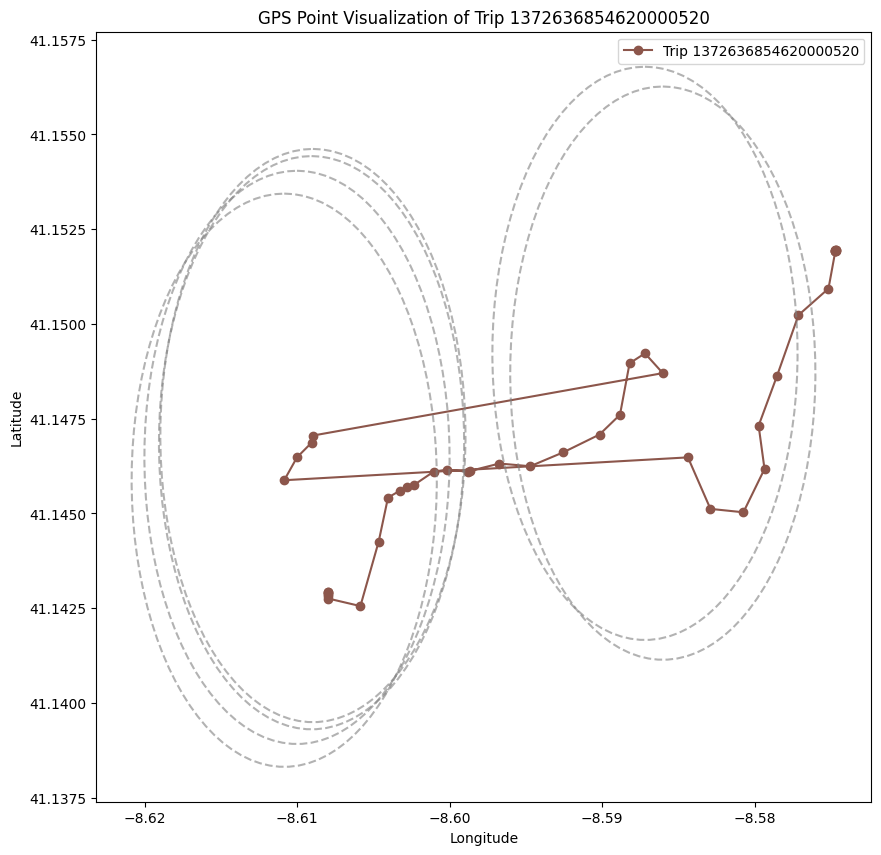

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from geopy.distance import geodesic
from geopy import Point

def plot_trip_gps_points_with_circles(gps_data, trip_id, radius_km=1.25, color='#8c564b', num_points=100, circle_indices=[22, 23, 24, 25]):
    # Filter the data for the specific TRIP_ID
    trip_data = gps_data[gps_data['TRIP_ID'] == trip_id]

    # Create a plot with longitude on the x-axis and latitude on the y-axis
    plt.figure(figsize=(10, 10))
    plt.plot(trip_data['lon'], trip_data['lat'], marker='o', linestyle='-', color=color, label=f'Trip {trip_id}')

    # Plot circles only for points at indices in circle_indices
    for idx in circle_indices:
        if idx < len(trip_data):  # Ensure index is within bounds of the trip_data
            row = trip_data.iloc[idx]
            center_point = Point(row['lat'], row['lon'])
            circle_points = []

            # Generate points around the center point at a radius of radius_km
            for angle in np.linspace(0, 360, num_points):
                destination = geodesic(kilometers=radius_km).destination(center_point, angle)
                circle_points.append([destination.longitude, destination.latitude])

            # Convert the circle points to a numpy array and plot the circle
            circle_points = np.array(circle_points)
            plt.plot(circle_points[:, 0], circle_points[:, 1], linestyle='--', color='gray', alpha=0.6)  # Circle around the point

    # Add labels and title
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'GPS Point Visualization of Trip {trip_id}')
    plt.legend()

    # Show the plot
    plt.show()

# Choose the TRIP_ID you want to plot (in this case, Trip 65)
trip_id_to_plot = 1372636854620000520  # Replace this with the actual TRIP_ID of Trip 65

# Visualize the GPS points for the chosen trip with the color #8c564b and circles around points 22-25
plot_trip_gps_points_with_circles(gps_data, trip_id_to_plot, radius_km=0.84, color='#8c564b', circle_indices=[15, 16, 17, 18,19,20])


Indentify Outliers
==

In [ ]:
import numpy as np
import pandas as pd
from geopy.distance import geodesic
from geopy import Point

# Function to identify outliers based on the provided criteria
def identify_outliers(gps_data):
    # Step 1: Initialize the 'Is it an outlier' column
    gps_data['Is it an outlier'] = 'Not outlier'

    # Step 2: Calculate the geodesic distance of adjacent points
    gps_data['Adjacent Distance'] = 0.0  # Initialize column with 0
    for trip_id in gps_data['TRIP_ID'].unique():  # Iterate over each trip
        trip_data = gps_data[gps_data['TRIP_ID'] == trip_id]

        for i in range(1, len(trip_data)):
            prev_point = Point(trip_data.iloc[i-1]['lat'], trip_data.iloc[i-1]['lon'])
            curr_point = Point(trip_data.iloc[i]['lat'], trip_data.iloc[i]['lon'])
            distance = geodesic(prev_point, curr_point).km  # Geodesic distance in kilometers
            gps_data.loc[trip_data.index[i], 'Adjacent Distance'] = distance

    # Step 3: Identify points where the distance between adjacent points is >= 6.25 km
    for trip_id in gps_data['TRIP_ID'].unique():
        trip_data = gps_data[gps_data['TRIP_ID'] == trip_id]

        for i in range(1, len(trip_data)):
            if trip_data.iloc[i]['Adjacent Distance'] >= 0.625:
                # Step 4: Check the next 9 points starting from the current point
                for j in range(i+1, min(i+10, len(trip_data))):  # Check up to 9 points ahead
                    if trip_data.iloc[j]['Adjacent Distance'] >= 0.625:
                        # Mark the points as outliers if the condition is met
                        gps_data.loc[trip_data.index[i:j], 'Is it an outlier'] = 'Outlier'


    return gps_data

gps_data2=gps_data
# Call the function to identify outliers
gps_data_with_outliers = identify_outliers(gps_data2)

# Display the updated DataFrame with outliers

gps_data_with_outliers.to_csv('gps_data_with_outliers.csv', index=False)
gps_data_with_outliers.head(10)

,TRIP_ID,lon,lat,LOF_Score,Is it an outlier,Adjacent Distance
0,1372636858620000589,-8.618643,41.141412,1.015188,Not outlier,0.000000
1,1372636858620000589,-8.618499,41.141376,0.956107,Not outlier,0.012733
2,1372636858620000589,-8.620326,41.142510,0.993088,Not outlier,0.198462
3,1372636858620000589,-8.622153,41.143815,1.033363,Not outlier,0.211022
4,1372636858620000589,-8.623953,41.144373,1.036638,Not outlier,0.163326
5,1372636858620000589,-8.626680,41.144778,1.041424,Not outlier,0.233311
6,1372636858620000589,-8.627373,41.144697,0.991660,Not outlier,0.058869
7,1372636858620000589,-8.630226,41.145210,0.961904,Not outlier,0.246194
8,1372636858620000589,-8.632746,41.146920,0.947789,Not outlier,0.284287
9,1372636858620000589,-8.631738,41.148225,1.030625,Not outlier,0.167824


In [ ]:
# Total number of points in gps_data_with_outliers
total_points = gps_data_with_outliers.shape[0]

# Number of points where 'Is it an outlier' is 'Outlier'
outlier_points = gps_data_with_outliers[gps_data_with_outliers['Is it an outlier'] == 'Outlier'].shape[0]

# Calculate the number of unique trip IDs with outlier points
outlier_trip_ids = gps_data_with_outliers[gps_data_with_outliers['Is it an outlier'] == 'Outlier']['TRIP_ID'].nunique()

# Calculate the total number of unique trip IDs
total_trip_ids = gps_data_with_outliers['TRIP_ID'].nunique()

# Calculate the percentage of trip IDs with outlier points
outlier_trip_percentage = (outlier_trip_ids / total_trip_ids) * 100

# Print the results
print(f"Total number of points: {total_points}")
print(f"Number of outlier points: {outlier_points}")
print(f"Percentage of trip IDs with outlier points: {outlier_trip_percentage:.2f}%")


Total number of points: 71697
Number of outlier points: 225
Percentage of trip IDs with outlier points: 5.54%


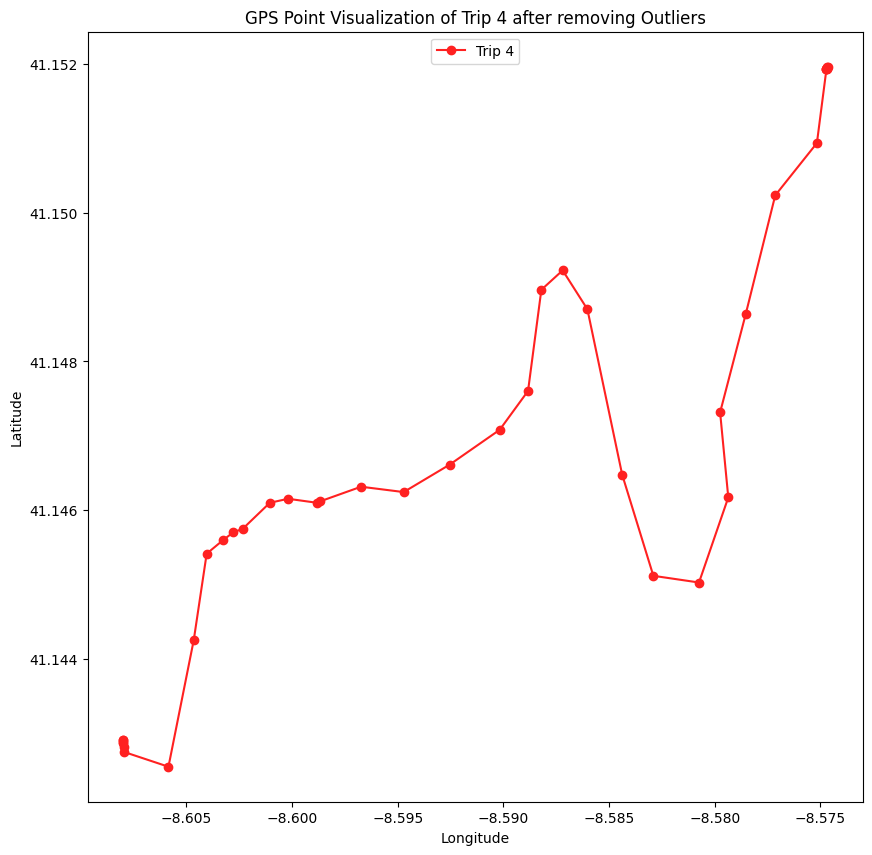

In [ ]:
import matplotlib.pyplot as plt

def plot_trip_gps_points_tripnum_filtered(gps_data, trip_id, tripnum, color,titlestring):
    # Filter the data for the specific TRIP_ID and only keep the rows where 'Is it an outlier' == 'Not outlier'
    trip_data = gps_data[(gps_data['TRIP_ID'] == trip_id) & (gps_data['Is it an outlier'] == 'Not outlier')]

    # Check if there are points to plot
    if not trip_data.empty:
        # Create a plot with longitude on the x-axis and latitude on the y-axis
        plt.figure(figsize=(10, 10))
        plt.plot(trip_data['lon'], trip_data['lat'], marker='o', linestyle='-', color=color, label=f'Trip {tripnum}')

        # Add labels and title
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.title(f'GPS Point Visualization of Trip {tripnum} {titlestring}')
        plt.legend()

        # Place the legend at the center top of the plot
        plt.legend(loc='upper center', fontsize='medium', ncol=1)

        # Show the plot
        plt.show()
    else:
        print(f"No valid data available for Trip ID {trip_id} where 'Is it an outlier' = 'Not outlier'.")

# Example usage
trip_id_to_plot = 1372636854620000520
tripnum = 4
color='#FF2121'

# Visualize the GPS points for the chosen trip, where 'Is it an outlier' == 'Not outlier'
plot_trip_gps_points_tripnum_filtered(gps_data_with_outliers, trip_id_to_plot, tripnum, color,'after removing Outliers')


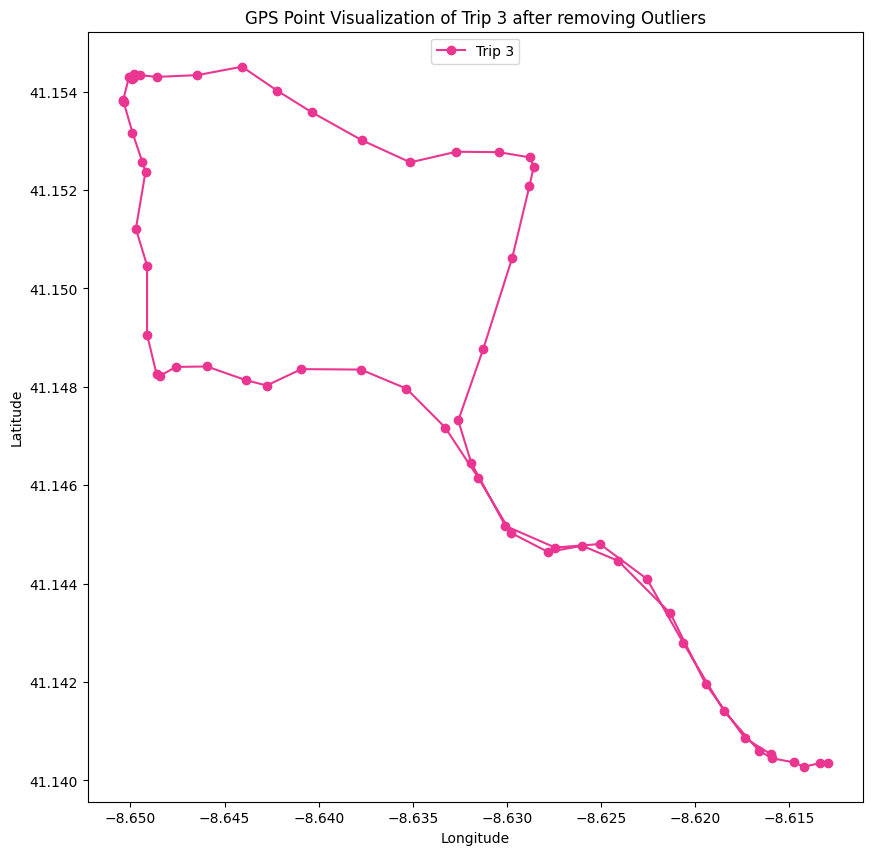

In [ ]:
trip_id_to_plot = 1372636951620000320
tripnum = 3
color='#ea3690'
# Visualize the GPS points for the chosen trip, where 'Is it an outlier' == 'Not outlier'
plot_trip_gps_points_tripnum_filtered(gps_data_with_outliers, trip_id_to_plot, tripnum, color,'after removing Outliers')

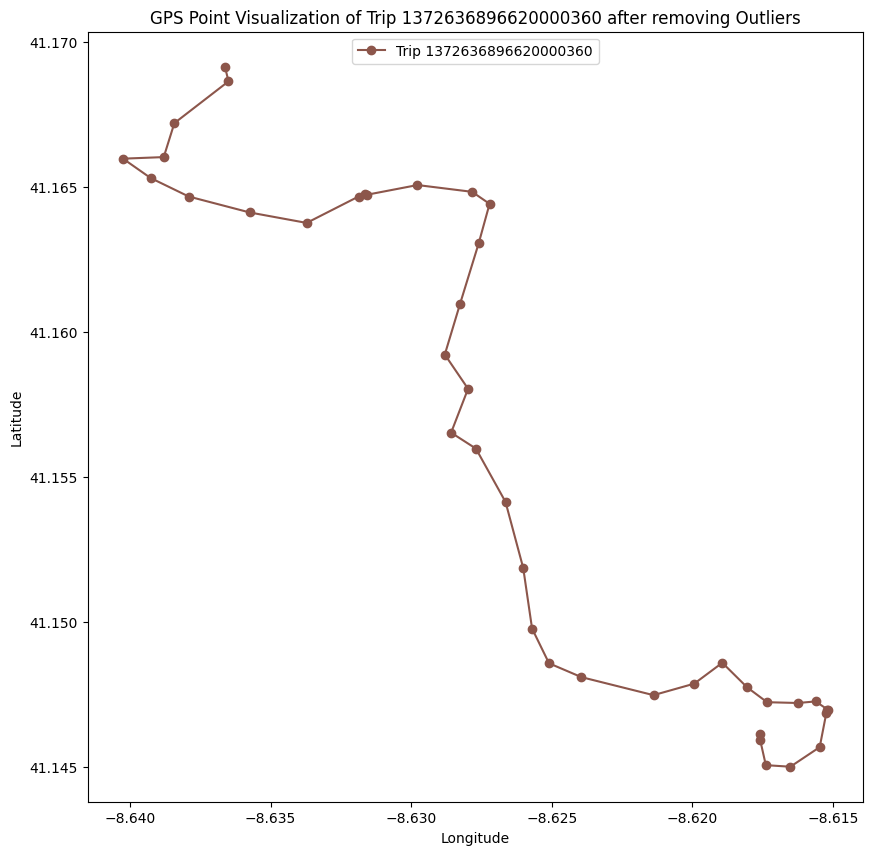

In [ ]:
trip_id_to_plot = 1372636896620000360
tripnum = 1372636896620000360
color='#8c564b'
# Visualize the GPS points for the chosen trip, where 'Is it an outlier' == 'Not outlier'
plot_trip_gps_points_tripnum_filtered(gps_data_with_outliers, trip_id_to_plot, tripnum, color,'after removing Outliers')

First 15 trips without outliers
==

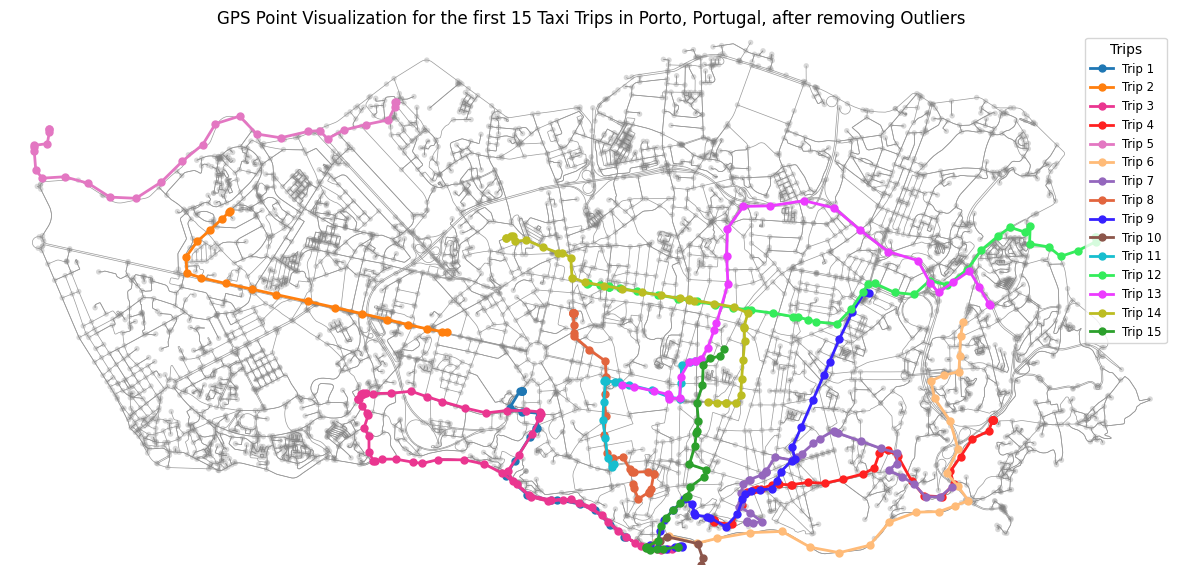

In [ ]:
import matplotlib.pyplot as plt
import osmnx as ox
# Define the city name and load the road network
city_name = "Porto, Portugal"
road_network = ox.graph_from_place(city_name, network_type='drive')

def enhanced_plot_gps_points(gps_data, road_network):
    fig, ax = plt.subplots(figsize=(15, 15))

    # Plot the road network with a cleaner background
    ox.plot_graph(
        road_network, ax=ax, bgcolor='white',
        node_color='gray', node_alpha=0.3, edge_linewidth=0.5,
        show=False, close=False
    )

    # Get unique TRIP_IDs and select the first 15 trips
    unique_trips = gps_data['TRIP_ID'].unique()[:15]

    # Define a custom color list with 15 distinct colors
    custom_colors = [
        '#1f77b4', '#ff7f0e', '#ea3690', '#FF2121', '#e377c2',
        '#ffbb78', '#9467bd', '#e2653e', '#3621FF', '#8c564b',
        '#17becf', '#34ec5B', '#EC3BFF', '#bcbd22', '#2ca02c'
    ]

    for i, trip_id in enumerate(unique_trips):
        trip = gps_data[gps_data['TRIP_ID'] == trip_id]

        # Select color from custom color list
        color = custom_colors[i % len(custom_colors)]

        # Plot each trip with its specific color
        ax.plot(
            trip['lon'], trip['lat'],
            marker='o', linestyle='-', linewidth=2,
            markersize=5, color=color, label=f'Trip {i+1}'
        )

    # Add a legend to differentiate trips
    plt.legend(title="Trips", loc='upper right', fontsize='small')
    plt.title("GPS Point Visualization for the first 15 Taxi Trips in Porto, Portugal, after removing Outliers")
    plt.show()

# Run the enhanced plot function
enhanced_plot_gps_points(gps_data_with_outliers[gps_data_with_outliers['Is it an outlier'] == 'Not outlier'], road_network)


In [ ]:
# Step 1: Filter the outliers
outliers_data = gps_data_with_outliers[gps_data_with_outliers['Is it an outlier'] == 'Outlier']

# Step 2: Group by 'TRIP_ID' and count the outliers for each trip
outlier_counts = outliers_data.groupby('TRIP_ID').size()

# Step 3: Find the trip with the maximum outliers
trip_with_max_outliers = outlier_counts.idxmax()

# Step 4: Get the count of outliers for that trip
max_outliers_count = outlier_counts.max()

# Output the result
print(f"The trip ID with the maximum number of outliers is: {trip_with_max_outliers} with {max_outliers_count} outlier points.")


The trip ID with the maximum number of outliers is: 1372653635620000665 with 11 outlier points.


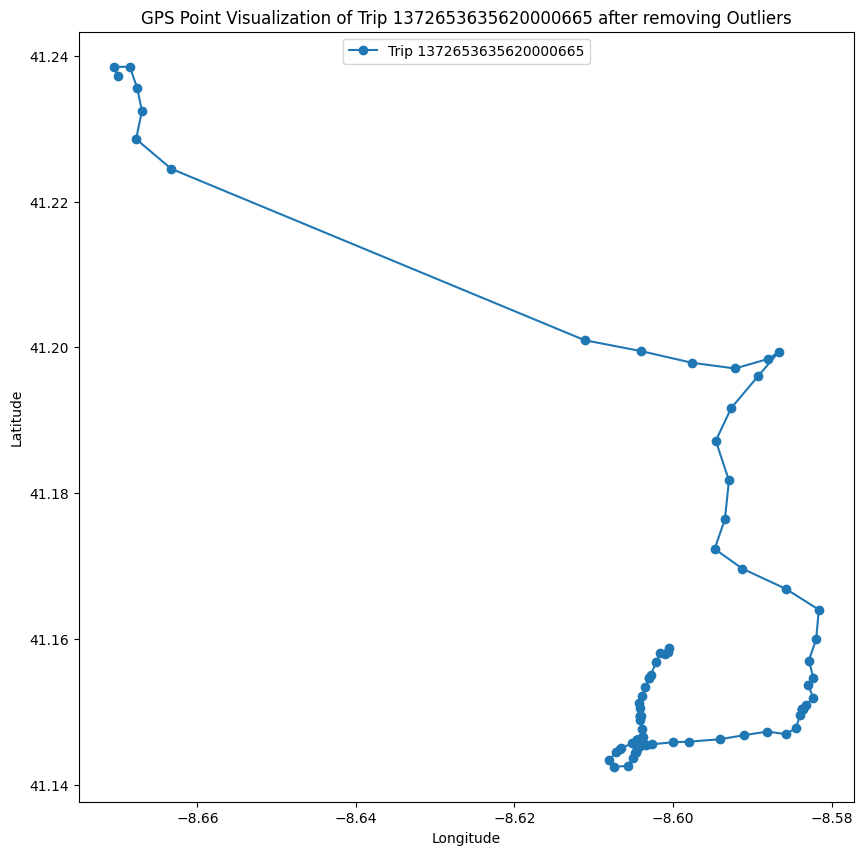

In [ ]:
trip_id_to_plot = 1372653635620000665
tripnum = 1372653635620000665
color='#1f77b4'
# Visualize the GPS points for the chosen trip, where 'Is it an outlier' == 'Not outlier'
plot_trip_gps_points_tripnum_filtered(gps_data_with_outliers, trip_id_to_plot, tripnum, color,'after removing Outliers')

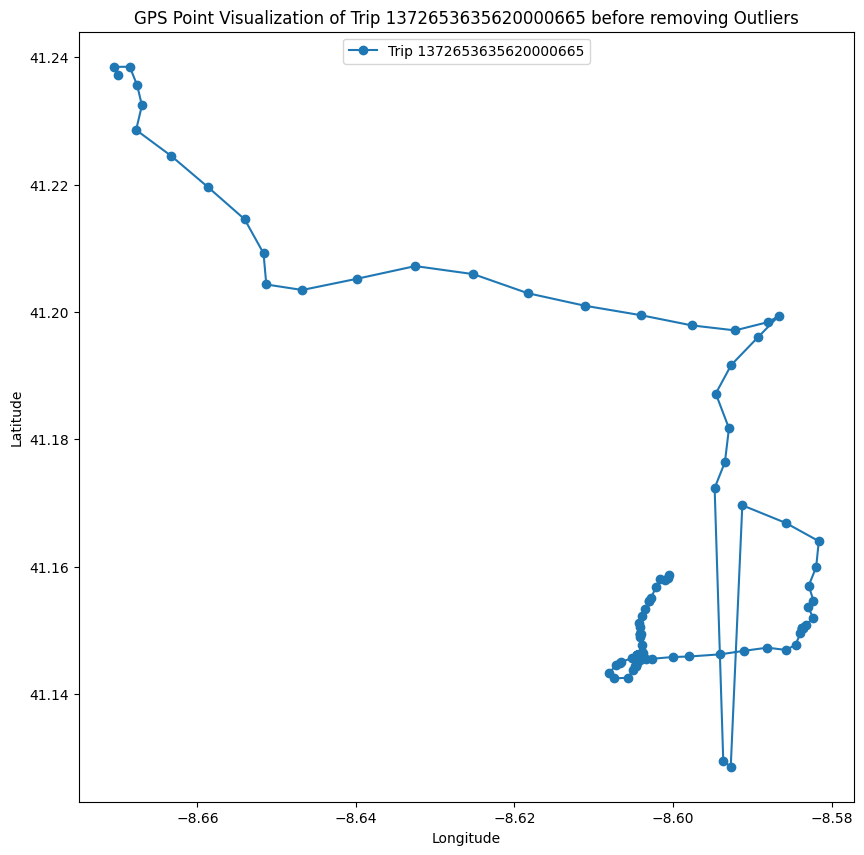

In [ ]:
trip_id_to_plot = 1372653635620000665
tripnum = 1372653635620000665
color='#1f77b4'
# Visualize the GPS points for the chosen trip with the color #8c564b
plot_trip_gps_points_tripnum(gps_data, trip_id_to_plot, tripnum,color)

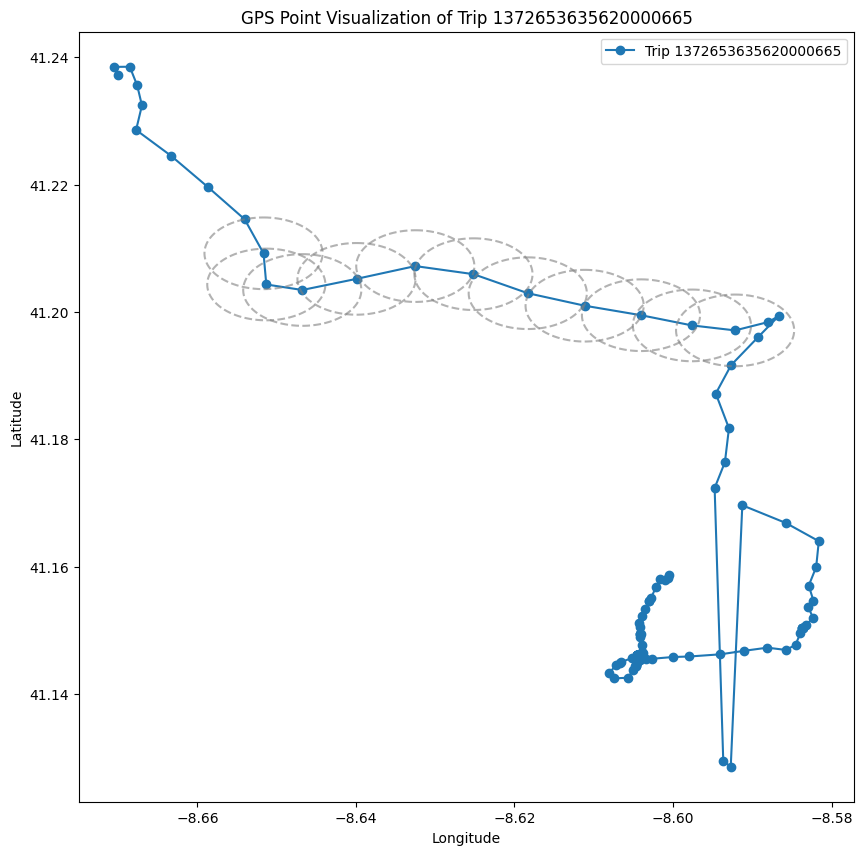

In [ ]:
# Choose the TRIP_ID you want to plot (in this case, Trip 65)
trip_id_to_plot = 1372653635620000665  # Replace this with the actual TRIP_ID of Trip 65

# Visualize the GPS points for the chosen trip with the color #8c564b and circles around points 22-25
plot_trip_gps_points_with_circles(gps_data, trip_id_to_plot, radius_km=0.625, color='#1f77b4', circle_indices=[90, 91, 92, 93,94,95,96,97,98,99,100])

Outliers Analysis
==

In [ ]:
# Step 1: Filter the data for Adjacent Distance > 0.625 km
filtered_data = gps_data_with_outliers[gps_data_with_outliers['Adjacent Distance'] > 0.625]

# Step 2: Find the row with the smallest Adjacent Distance
min_distance_row = filtered_data.loc[filtered_data['Adjacent Distance'].idxmin()]

# Step 3: Extract the smallest Adjacent Distance and the corresponding TRIP_ID
min_adjacent_distance = min_distance_row['Adjacent Distance']
trip_id_of_min_distance = min_distance_row['TRIP_ID']

# Output the result
print(f"The smallest Adjacent Distance exceeding 0.625 km is {min_adjacent_distance} km, from Trip ID: {trip_id_of_min_distance}")


The smallest Adjacent Distance exceeding 0.625 km is 0.6253390824070121 km, from Trip ID: 1372670452620000488


In [ ]:
# Step 1: Filter the data for Adjacent Distance <= 0.625 km
filtered_data = gps_data_with_outliers[gps_data_with_outliers['Adjacent Distance'] <= 0.625]

# Step 2: Find the row with the maximum Adjacent Distance
max_distance_row = filtered_data.loc[filtered_data['Adjacent Distance'].idxmax()]

# Step 3: Extract the maximum Adjacent Distance and the corresponding TRIP_ID
max_adjacent_distance = max_distance_row['Adjacent Distance']
trip_id_of_max_distance = max_distance_row['TRIP_ID']

# Output the result
print(f"The maximum Adjacent Distance less than or equal to 0.625 km is {max_adjacent_distance} km, from Trip ID: {trip_id_of_max_distance}")


The maximum Adjacent Distance less than or equal to 0.625 km is 0.6243168765931951 km, from Trip ID: 1372650914620000434


Distribution of outliers across trips:
1      4
2     62
3      5
4      4
5      1
6      1
8      3
9      1
11     2
Name: count, dtype: int64


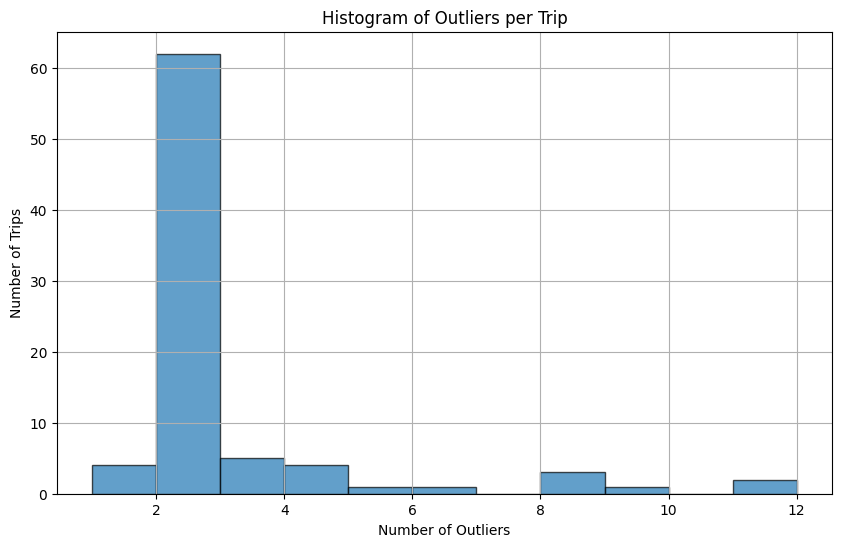

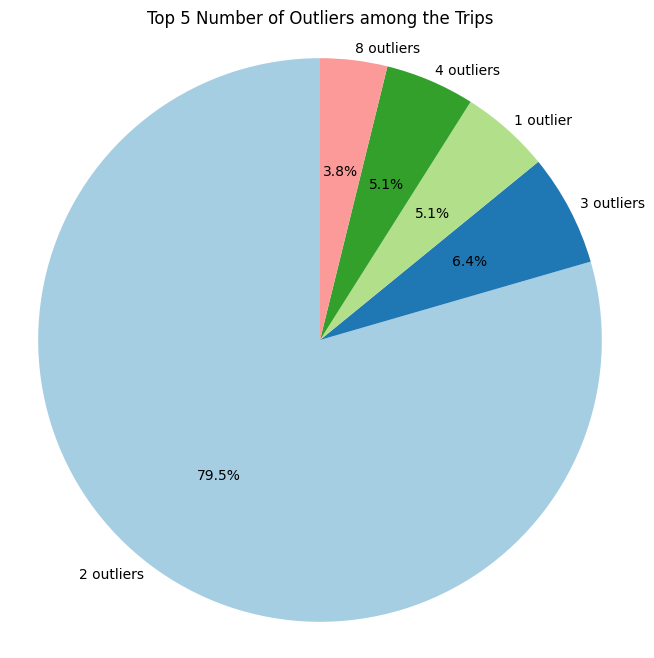

In [ ]:
import matplotlib.pyplot as plt


# Step 1: Filter the outliers
outliers_data = gps_data_with_outliers[gps_data_with_outliers['Is it an outlier'] == 'Outlier']

# Step 2: Group by 'TRIP_ID' and count the outliers for each trip
outlier_counts = outliers_data.groupby('TRIP_ID').size()

# Step 3: Count how many trips have 1, 2, 3, ... outliers
outlier_counts_distribution = outlier_counts.value_counts().sort_index()

# Step 4: Output the distribution of outliers
print("Distribution of outliers across trips:")
print(outlier_counts_distribution)

# Step 5: Plot the histogram to show the distribution of outliers per trip
plt.figure(figsize=(10, 6))
plt.hist(outlier_counts, bins=range(1, outlier_counts.max() + 2), edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('Number of Outliers')
plt.ylabel('Number of Trips')
plt.title('Histogram of Outliers per Trip')

# Show grid
plt.grid(True)

# Show the plot
plt.show()


# Step 4: Sort the outlier counts to get the top 5 most frequent outlier counts
top_5_outliers = outlier_counts_distribution.nlargest(5)

# Step 5: Plot a pie chart to show the percentage of trips with a specific number of outliers
# Creating labels and values for the pie chart
labels = [f'{count} outlier' if count == 1 else f'{count} outliers' for count in top_5_outliers.index]
sizes = top_5_outliers.values

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors, labeldistance=1.04)
plt.title('Top 5 Number of Outliers among the Trips')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.

# Show the pie chart
plt.show()



In [ ]:
import pandas as pd
import folium
from IPython.display import IFrame


# Plotting function with outlier removal
def plot_segments_for_trip_id(snapped_gps_data, trip_id, indices_to_remove=None, remove_outliers=False):
    """
    Creates an interactive map for a specific TRIP_ID using lat and lon points.

    Args:
        snapped_gps_data (pd.DataFrame): DataFrame containing lat, lon, and TRIP_ID columns.
        trip_id (int): The TRIP_ID to visualize.
        indices_to_remove (list, optional): List of indices to remove before plotting.
        remove_outliers (bool, optional): Whether to exclude points marked as outliers.

    Returns:
        folium.Map: Interactive map with plotted trip segments.
    """
    # Filter for the specified TRIP_ID
    trip_data = snapped_gps_data[snapped_gps_data['TRIP_ID'] == trip_id].reset_index(drop=True)

    if trip_data.empty:
        print(f"No data found for TRIP_ID: {trip_id}")
        return None

    # Optionally remove outliers
    if remove_outliers:
        trip_data = trip_data[trip_data['Is it an outlier'] != 'Outlier'].reset_index(drop=True)

    # Remove points based on the provided indices, if any
    if indices_to_remove is not None:
        print(f"Removing points at indices: {indices_to_remove}")
        trip_data = trip_data.drop(indices_to_remove).reset_index(drop=True)

    # Print debug information
    print(f"Data found for TRIP_ID {trip_id} after processing: {trip_data.shape[0]} points")

    # Center the map on the mean latitude and longitude
    map_center = [trip_data['lat'].mean(), trip_data['lon'].mean()]
    m = folium.Map(location=map_center, zoom_start=14)

    # Plot the entire trip as one continuous line
    folium.PolyLine(
        locations=[(row['lat'], row['lon']) for _, row in trip_data.iterrows()],
        color="blue",
        weight=5,
        opacity=0.7,
        tooltip=f"TRIP_ID: {trip_id}"
    ).add_to(m)

    # Add markers for each point along the trip
    for index, row in trip_data.iterrows():
        folium.CircleMarker(
            location=(row['lat'], row['lon']),
            radius=3,
            color="red",
            fill=True,
            fill_color="red",
            popup=f"Index: {index}, Adjacent Distance: {row['Adjacent Distance']}",
            tooltip=f"Index: {index}"  # Tooltip with index for quick view
        ).add_to(m)

    return m

In [ ]:
# Replace with the TRIP_ID you want to visualize
trip_id = 1372636854620000520      # Example TRIP_ID, replace with an actual ID from your dataset

# Generate the map with outlier removal enabled
interactive_map = plot_segments_for_trip_id(gps_data_with_outliers, trip_id, remove_outliers=False)

if interactive_map:
    # Save and display the map
    interactive_map.save("1372636854620000520_outliers.html")
    display(IFrame("trip_segments_map.html", width=1000, height=500))

In [ ]:
# Replace with the TRIP_ID you want to visualize
trip_id = 1372636854620000520      # Example TRIP_ID, replace with an actual ID from your dataset

# Generate the map with outlier removal enabled
interactive_map = plot_segments_for_trip_id(gps_data_with_outliers, trip_id, remove_outliers=True)

if interactive_map:
    # Save and display the map
    interactive_map.save("1372636854620000520_no_outliers.html")
    display(IFrame("trip_segments_map.html", width=1000, height=500))